# test BCHydro gmpe model

In [2]:
# BChydro gmpe for backarc events

import numpy as np

from openquake.hazardlib.gsim.abrahamson_2015 import (
    AbrahamsonEtAl2015SInter,  # BC Hydro: interface
    AbrahamsonEtAl2015SSlab    # BC Hydro: in-slab
)

# from openquake.hazardlib.gsim.boore_2014 import BooreEtAl2014

from openquake.hazardlib.imt import PGA, PGV,SA
from openquake.hazardlib.const import StdDev
from openquake.hazardlib.contexts import SitesContext, DistancesContext, RuptureContext

import matplotlib.pyplot as plt

import matplotlib as mpl

mpl.style.use('seaborn-v0_8-paper')



In [ ]:
from openquake.hazardlib import gsim

# gs = gsim.get_available_gsims()
# print(gs)          # number of GSIMs
# print(sorted(gs)[:10])  # peek at a few names

# BChydrop model
# gsim = AbrahamsonEtAl2015SInter()


# Example of Atkinson 2022 and Abrahamson_Guelerce2020 for NZ subduction events

from openquake.hazardlib.gsim.nz22 import atkinson_2022,nz_nshm2022_abrahamson_gulerce_2020
gsim = atkinson_2022.Atkinson2022Crust()
# gsim = nz_nshm2022_abrahamson_gulerce_2020.NZNSHM2022_AbrahamsonGulerce2020SSlab()


# Global version:

# from openquake.hazardlib.gsim.abrahamson_gulerce_2020 import  AbrahamsonGulerce2020SInter
# gsim = AbrahamsonGulerce2020SInter()

print("Sites:", gsim.REQUIRES_SITES_PARAMETERS)
print("Rupture:", gsim.REQUIRES_RUPTURE_PARAMETERS)
print("Dists:", gsim.REQUIRES_DISTANCES)

# gsim.get_mean_and_stddevs()

Sites: frozenset({'vs30'})
Rupture: frozenset({'mag'})
Dists: frozenset({'rrup'})


In [24]:
# --- inputs ---
N = 120
rhypo = np.logspace(1.2, 2.7, N)      # km (strictly positive) # if r_rup used, then rrup

vs30  = np.full(N, 400.0)            # m/s
backarc_flag = False
              # True if site is in backarc; else False
Mw = 5
hypo_depth = 50.0                    # km
ztor = 50.0                         # requried for AG20

# --- build contexts ---
sites = SitesContext()
sites.sids = np.arange(N, dtype=int)            # REQUIRED int ids
sites.vs30 = vs30.astype(float)                 # REQUIRED
sites.vs30measured = np.zeros(N, dtype=bool)    # False if inferred
sites.backarc = np.full(N, backarc_flag, dtype=bool)  # REQUIRED for BC Hydro

# Optional basin proxies; NaN is OK if model infers/ignores them

dists = DistancesContext()
dists.rhypo = rhypo.astype(float)               # REQUIRED for in-slab
dists.rrup = rhypo.astype(float)

rup = RuptureContext()
rup.mag = float(Mw)                              # REQUIRED
rup.hypo_depth = float(hypo_depth)              # REQUIRED for in-slab
rup.ztor = np.full(N, ztor)


# --- compute ---
# gsim = AbrahamsonEtAl2015SInter()

imt = PGA()
mean_ln, [sigma_tot] = gsim.get_mean_and_stddevs(sites, rup, dists,imt, [StdDev.TOTAL])

# BC Hydro returns ln(PGA in g); convert if needed
pga_g = np.exp(mean_ln)
pga_mps2 = pga_g * 9.80665
print(pga_g[:5], sigma_tot[:5])




[0.05047833 0.04841632 0.04642095 0.04449137 0.04262662] [0.6609733 0.6609733 0.6609733 0.6609733 0.6609733]


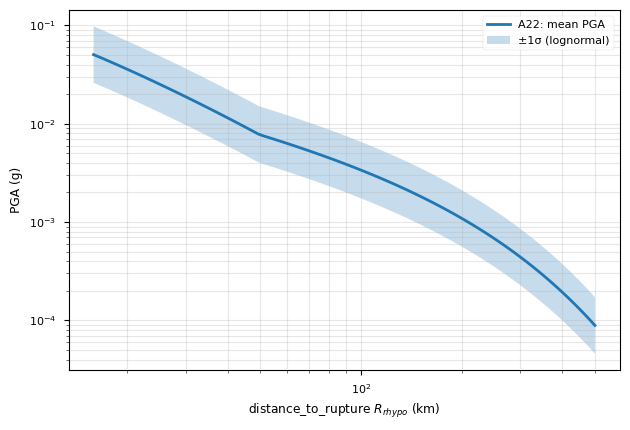

In [25]:

import matplotlib.pyplot as plt
import matplotlib as mpl


# BC Hydro returns ln(PGA in g)
pga_g = np.exp(mean_ln)
pga_hi = np.exp(mean_ln + sigma_tot)   # +1σ band (g)
pga_lo = np.exp(mean_ln - sigma_tot)   # -1σ band (g)

# ---- Plot (log–log) ----
mask = np.isfinite(rhypo) & np.isfinite(pga_g) & (rhypo > 0) & (pga_g > 0)
R = rhypo[mask]; y = pga_g[mask]; ylo = pga_lo[mask]; yhi = pga_hi[mask]

fig, ax = plt.subplots()
ax.plot(R, y, lw=2, label="A22: mean PGA")
ax.fill_between(R, ylo, yhi, alpha=0.25, label="±1σ (lognormal)")

ax.set_xscale("log"); 
ax.set_yscale("log");


ax.set_xlabel("distance_to_rupture $R_{rhypo}$ (km)")
ax.set_ylabel("PGA (g)")
ax.grid(True, which="both", alpha=0.3)

ax.legend()

plt.tight_layout()
plt.show()

In [12]:
import pandas as pd
from pathlib import Path


In [26]:
# Magnitudes to loop over
magnitudes = [4.0,4.5,5.0, 5.5,6.0]

# Output directory
# outdir = Path("atk22_backarc")
# outdir = Path("bchydro_forearc")
outdir = Path("atk22_forearc")
# outdir = Path('ag20_forearc')

backarc_flag=False

outdir.mkdir(parents=True, exist_ok=True)

sites = SitesContext()
sites.sids = np.arange(N, dtype=int)            # REQUIRED int ids
sites.vs30 = vs30.astype(float) 
sites.backarc = np.full(N, backarc_flag, dtype=bool)  # REQUIRED for BC Hydro

# imt = PGA() 

ped_list = [0.02,0.04,0.06,0.08,0.1,0.2,0.5,1.0,2.0,5.0,10.0]
name_list = ['002','004','006','008','01','02','05','1','2','5','10']

for ipd,ped in enumerate(ped_list):

    imt = SA(ped)
    # gsim = AbrahamsonEtAl2015SSlab()
    # ------------

    for Mw in magnitudes:
        rup = RuptureContext()
        rup.mag = float(Mw)

        dists = DistancesContext()
        dists.rrup = rhypo.astype(float)
        
        # rup.hypo_depth = float(hypo_depth)
        rup.ztor = float(ztor)

                        # REQUIRED
        # sites.backarc = np.full(N, backarc_flag, dtype=bool)  # REQUIRED for BC Hydro

        mean_ln, [sigma_tot] = gsim.get_mean_and_stddevs(
            sites, rup, dists, imt, [StdDev.TOTAL]
        )
        # mean_ln is ln(PGA in g); sigma_tot is the total lognormal sigma

        # Assemble and save CSV
        df = pd.DataFrame({
            "rrup_km": rhypo,
            "mean_ln": mean_ln,          # ln(PGA or SA in g)
            "sigma_tot": sigma_tot       # lognormal (natural-log) std. dev.
        })
        csv_path = outdir / f"atk22_inter_sa{name_list[ipd]}_Mw{np.round(Mw,1)}.csv"
        df.to_csv(csv_path, index=False)
        print(f"Wrote {csv_path}")
# 
print("Done.")

Wrote atk22_forearc/atk22_inter_sa002_Mw4.0.csv
Wrote atk22_forearc/atk22_inter_sa002_Mw4.5.csv
Wrote atk22_forearc/atk22_inter_sa002_Mw5.0.csv
Wrote atk22_forearc/atk22_inter_sa002_Mw5.5.csv
Wrote atk22_forearc/atk22_inter_sa002_Mw6.0.csv
Wrote atk22_forearc/atk22_inter_sa004_Mw4.0.csv
Wrote atk22_forearc/atk22_inter_sa004_Mw4.5.csv
Wrote atk22_forearc/atk22_inter_sa004_Mw5.0.csv
Wrote atk22_forearc/atk22_inter_sa004_Mw5.5.csv
Wrote atk22_forearc/atk22_inter_sa004_Mw6.0.csv
Wrote atk22_forearc/atk22_inter_sa006_Mw4.0.csv
Wrote atk22_forearc/atk22_inter_sa006_Mw4.5.csv
Wrote atk22_forearc/atk22_inter_sa006_Mw5.0.csv
Wrote atk22_forearc/atk22_inter_sa006_Mw5.5.csv
Wrote atk22_forearc/atk22_inter_sa006_Mw6.0.csv
Wrote atk22_forearc/atk22_inter_sa008_Mw4.0.csv
Wrote atk22_forearc/atk22_inter_sa008_Mw4.5.csv
Wrote atk22_forearc/atk22_inter_sa008_Mw5.0.csv
Wrote atk22_forearc/atk22_inter_sa008_Mw5.5.csv
Wrote atk22_forearc/atk22_inter_sa008_Mw6.0.csv
Wrote atk22_forearc/atk22_inter_sa01_Mw4

0.0

In [ ]:
# Test polygon distance functions

import sys

sys.path.append('/Users/DuoL/Documents/PythonPath/')

from GMfunc.functions_polygon import point_to_polygon_distance, point_to_polygon_distance_vectorized

# Define test polygons
rectangle = [(0, 0), (4, 0), (4, 3), (0, 3)]  # Rectangle
triangle = [(0, 0), (3, 0), (1.5, 2)]  # Triangle
irregular = [(0, 0), (2, 0), (3, 1), (2, 3), (0, 2)]  # Irregular pentagon

# Test points
test_points = [
    (2, 1.5),    # Inside rectangle
    (5, 1),      # Outside rectangle (right)
    (-1, 2),     # Outside rectangle (left)
    (2, 4),      # Outside rectangle (top)
    (1, 0.5),    # Inside triangle
    (4, 1),      # Outside triangle
]

print("=== Testing polygon distance functions ===")
print()

# Test single point function
print("Single point tests:")
for i, point in enumerate(test_points):
    print(f"Point {i+1}: {point}")
    
    # Test with rectangle
    dist_rect = point_to_polygon_distance(point, rectangle)
    print(f"  Distance to rectangle: {dist_rect:.3f}")
    
    # Test with triangle
    dist_tri = point_to_polygon_distance(point, triangle)
    print(f"  Distance to triangle: {dist_tri:.3f}")
    
    # Test with irregular polygon
    dist_irreg = point_to_polygon_distance(point, irregular)
    print(f"  Distance to irregular: {dist_irreg:.3f}")
    print()

# Test vectorized function
print("Vectorized test:")
distances_rect = point_to_polygon_distance_vectorized(test_points, rectangle)
distances_tri = point_to_polygon_distance_vectorized(test_points, triangle)

print("Distances to rectangle:", distances_rect)
print("Distances to triangle:", distances_tri)
print()


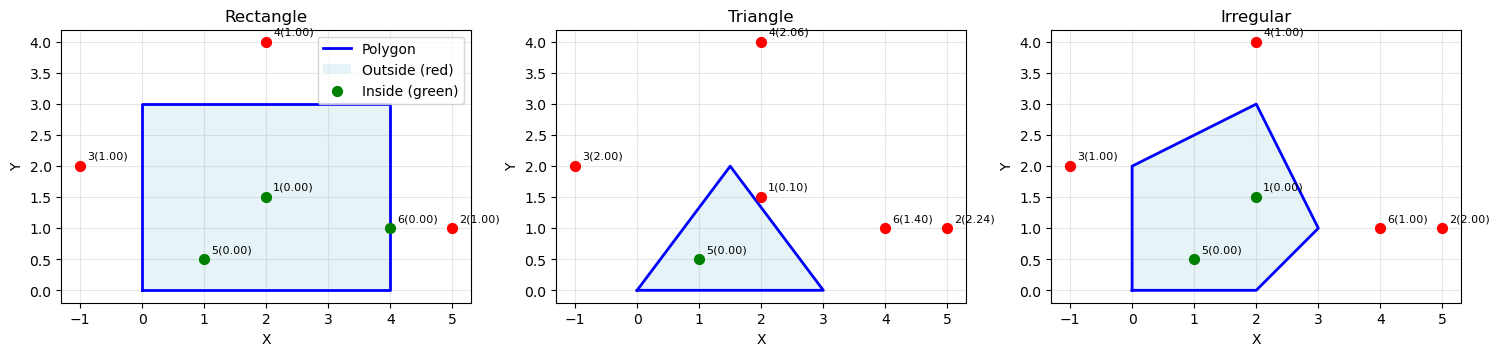

Legend: Green points are inside (distance=0), Red points are outside (distance>0)
Numbers show point index and calculated distance.


In [3]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

# Visualize results
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

polygons = [rectangle, triangle, irregular]
polygon_names = ['Rectangle', 'Triangle', 'Irregular']

for idx, (poly, name) in enumerate(zip(polygons, polygon_names)):
    ax = axes[idx]
    
    # Plot polygon
    poly_array = np.array(poly + [poly[0]])  # Close polygon
    ax.plot(poly_array[:, 0], poly_array[:, 1], 'b-', linewidth=2, label='Polygon')
    ax.fill(poly_array[:-1, 0], poly_array[:-1, 1], 'lightblue', alpha=0.3)
    
    # Plot test points
    for i, point in enumerate(test_points):
        if idx == 0:  # Rectangle
            dist = point_to_polygon_distance(point, rectangle)
        elif idx == 1:  # Triangle
            dist = point_to_polygon_distance(point, triangle)
        else:  # Irregular
            dist = point_to_polygon_distance(point, irregular)
        
        color = 'red' if dist > 0 else 'green'
        ax.scatter(point[0], point[1], c=color, s=50, zorder=5)
        ax.annotate(f'{i+1}({dist:.2f})', point, xytext=(5, 5), 
                   textcoords='offset points', fontsize=8)
    
    ax.set_title(f'{name}')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.grid(True, alpha=0.3)
    ax.set_aspect('equal')

# Add legend
axes[0].legend(['Polygon', 'Outside (red)', 'Inside (green)'], loc='upper right')

plt.tight_layout()
plt.show()

print("Legend: Green points are inside (distance=0), Red points are outside (distance>0)")
print("Numbers show point index and calculated distance.")